# Data integration and batch correction

An important task of single-cell analysis is the integration of several samples, which we can perform with omicverse. 

Here we demonstrate how to merge data using omicverse and perform a corrective analysis for batch effects. We provide a total of 4 methods for batch effect correction in omicverse, including harmony, scanorama and combat which do not require GPU, and SIMBA which requires GPU. if available, we recommend using GPU-based scVI and scANVI to get the best batch effect correction results.


In [1]:
import omicverse as ov
print(f"omicverse version: {ov.__version__}")
import scanpy as sc
print(f"scanpy version: {sc.__version__}")
ov.utils.ov_plot_set()

2023-08-09 19:38:10.498636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 19:38:15.109878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-09 19:38:15.109999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-09 19:38:15.110006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

omicverse version: 1.4.17
scanpy version: 1.9.1


## Data integration

First, we need to concat the data of scRNA-seq from different batch. We can use `sc.concat` to perform it。

The dataset we will use to demonstrate data integration contains several samples of bone marrow mononuclear cells. These samples were originally created for the Open Problems in Single-Cell Analysis NeurIPS Competition 2021.

We selected sample of `s1d3`, `s2d1` and `s3d7` to perform integrate. The individual data can be downloaded from [figshare](https://figshare.com/articles/dataset/omicverse-reproducibility_processed_data/23165636)

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [5]:
adata1=ov.read('neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [6]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We can see that there are now three elements in the batch

In [7]:
adata.obs['batch'].unique()

array(['s1d3', 's2d1', 's3d7'], dtype=object)

## Data preprocess and Batch visualize

We first performed quality control of the data and normalisation with screening for highly variable genes. Then visualise potential batch effects in the data.

Here, we can set `batch_key=batch` to correct the doublet detectation and Highly variable genes identifcation.

In [ ]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
              batch_key='batch')
adata

We can store the raw counts if we need the raw counts after filtered the HVGs.

In [9]:
ov.utils.store_layers(adata,layers='counts')
adata

......The X of adata have been stored in counts


AnnData object with n_obs × n_vars = 26970 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells'
    uns: 'scrublet', 'layers_counts'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key='batch')
adata

In [11]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 26970 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_features'
    uns: 'scrublet', 'layers_counts', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'

We can save the pre-processed data.

In [ ]:
adata.write_h5ad('neurips2021_batch_normlog.h5ad',compression='gzip')

Similarly, we calculated PCA for HVGs and visualised potential batch effects in the data using pymde. pymde is GPU-accelerated UMAP.

In [12]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm["X_mde_pca"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


There is a very clear batch effect in the data

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>]

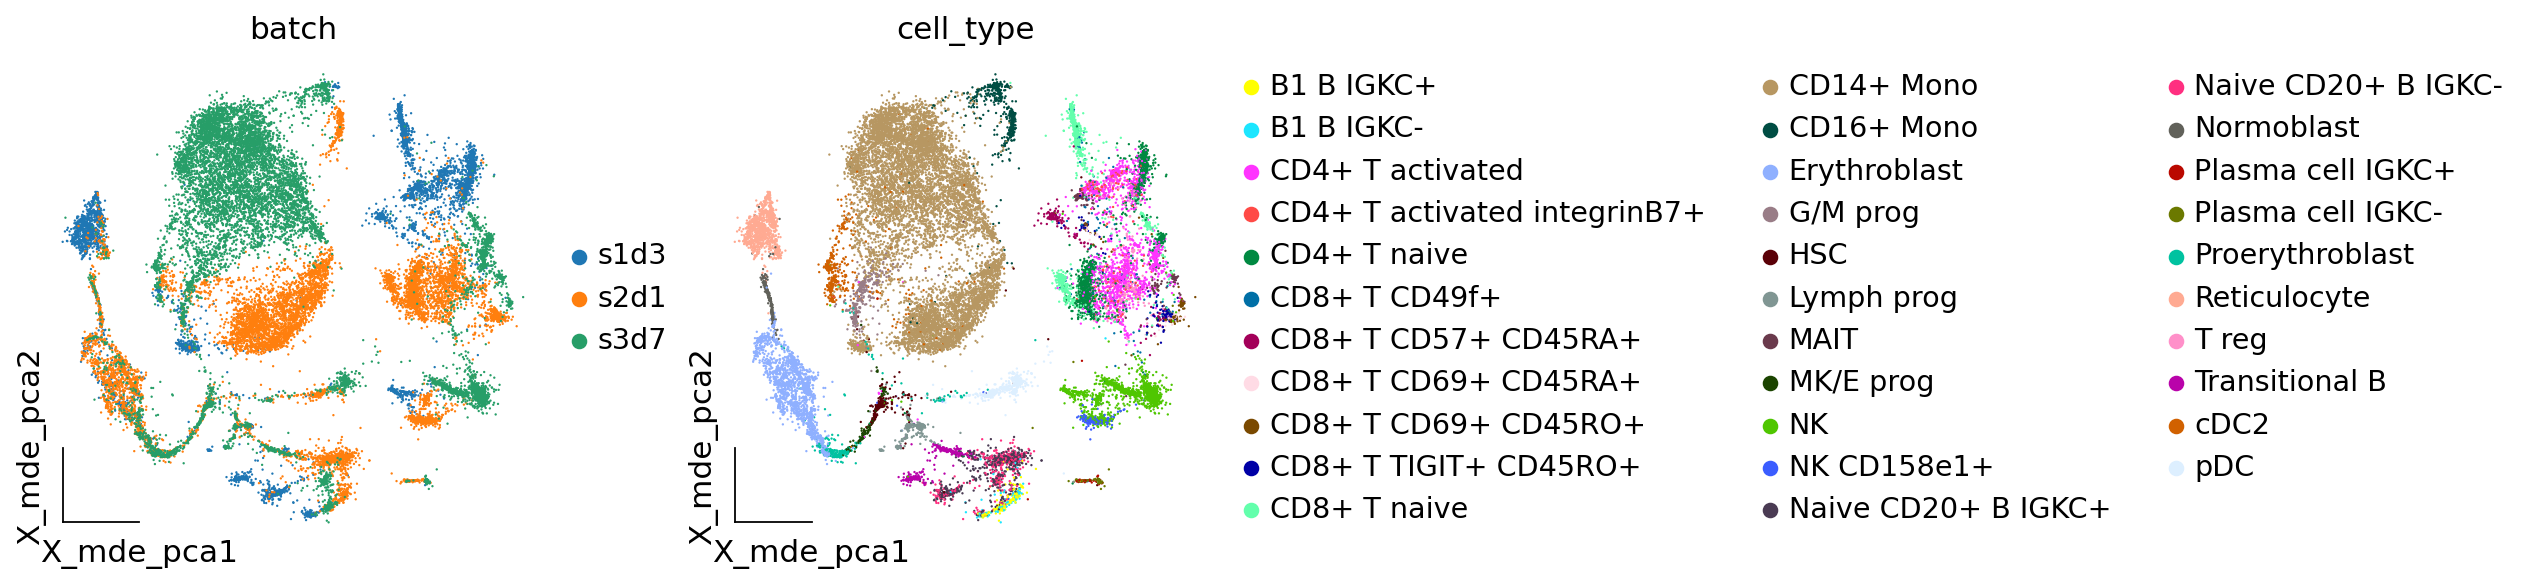

In [14]:
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['batch','cell_type'],show=False)

## Harmony

Harmony is an algorithm for performing integration of single cell genomics datasets. Please check out manuscript on [Nature Methods](https://www.nature.com/articles/s41592-019-0619-0).

![harmony](https://portals.broadinstitute.org/harmony/articles/main.jpg)

The function `ov.single.batch_correction` can be set in three methods: `harmony`,`combat` and `scanorama`

In [15]:
adata_harmony=ov.single.batch_correction(adata,batch_key='batch',
                                        methods='harmony',n_pcs=50)
adata

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2023-08-09 20:11:26,237 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-09 20:11:32,018 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-09 20:11:32,638 - harmonypy - INFO - Iteration 1 of 10
2023-08-09 20:11:39,694 - harmonypy - INFO - Iteration 2 of 10
2023-08-09 20:11:49,812 - harmonypy - INFO - Iteration 3 of 10
2023-08-09 20:11:57,063 - harmonypy - INFO - Iteration 4 of 10
2023-08-09 20:12:05,280 - harmonypy - INFO - Iteration 5 of 10
2023-08-09 20:12:12,581 - harmonypy - INFO - Iteration 6 of 10
2023-08-09 20:12:20,314 - harmonypy - INFO - Iteration 7 of 10
2023-08-09 20:12:26,035 - harmonypy - INFO - Iteration 8 of 10
2023-08-09 20:12:33,314 - harmonypy - INFO - Iteration 9 of 10
2023-08-09 20:12:38,633 - harmonypy - INFO - Iteration 10 of 10
2023-08-09 20:12:42,726 - harmonypy - INFO - Converged after 10 iterations


AnnData object with n_obs × n_vars = 26970 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_features'
    uns: 'scrublet', 'layers_counts', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'cel

In [16]:
adata.obsm["X_mde_harmony"] = ov.utils.mde(adata.obsm["X_harmony"])

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>]

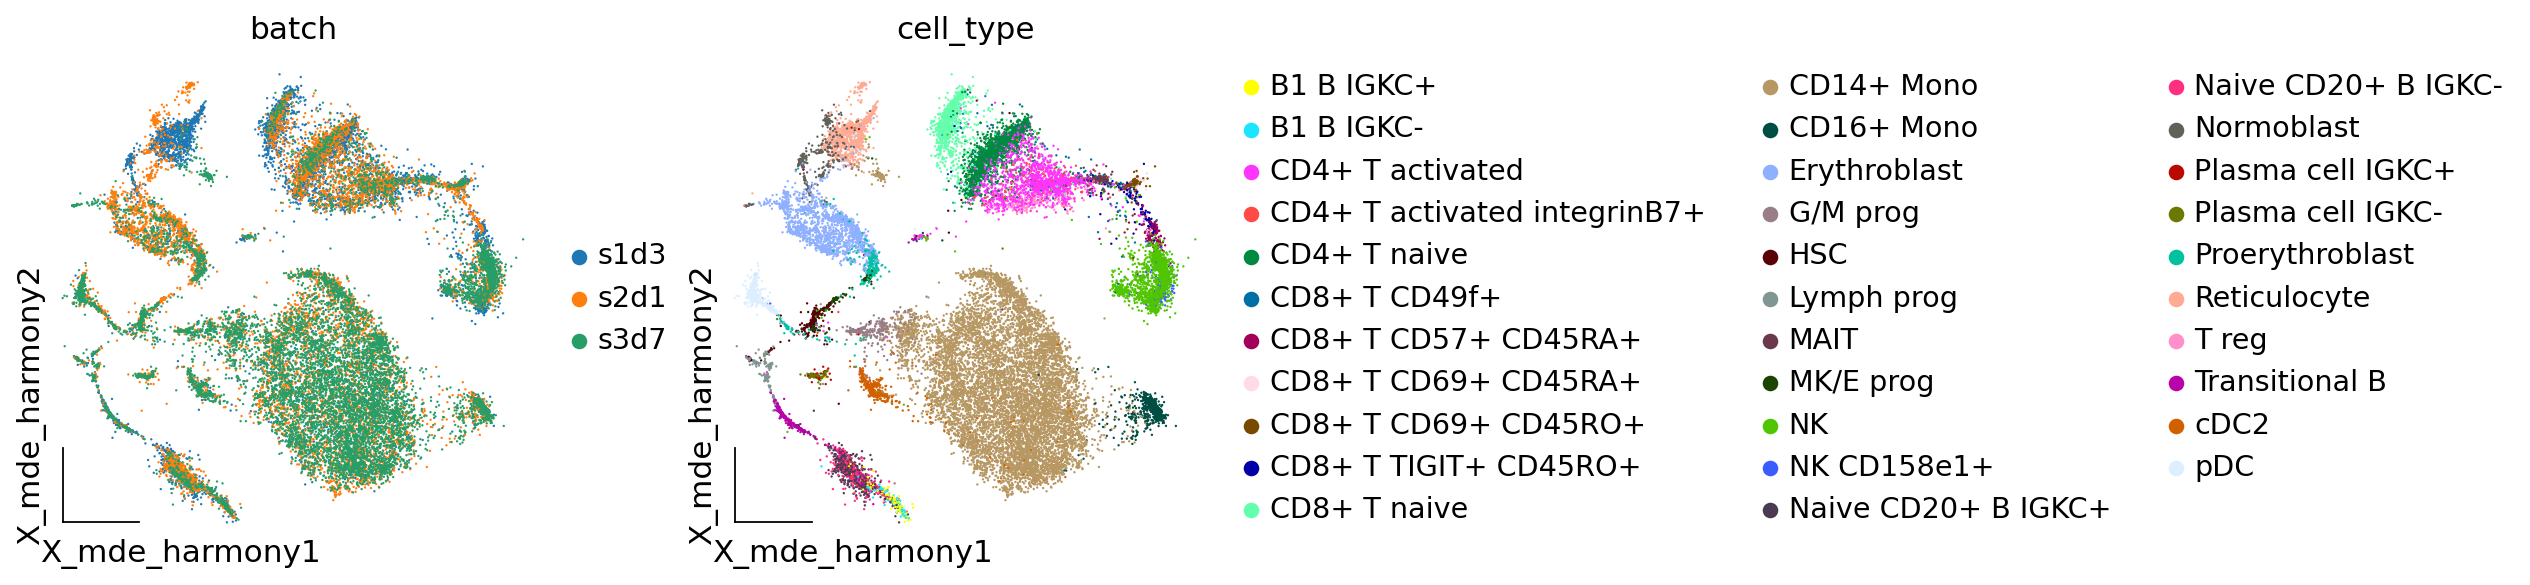

In [17]:
ov.utils.embedding(adata,
                basis='X_mde_harmony',frameon='small',
                color=['batch','cell_type'],show=False)

## Combat

combat is a batch effect correction method that is very widely used in bulk RNA-seq, and it works just as well on single-cell sequencing data.



In [20]:
adata_combat=ov.single.batch_correction(adata,batch_key='batch',
                                        methods='combat',n_pcs=50)
adata

Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



AnnData object with n_obs × n_vars = 26970 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_features'
    uns: 'scrublet', 'layers_counts', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'cel

In [21]:
adata.obsm["X_mde_combat"] = ov.utils.mde(adata.obsm["X_combat"])

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>]

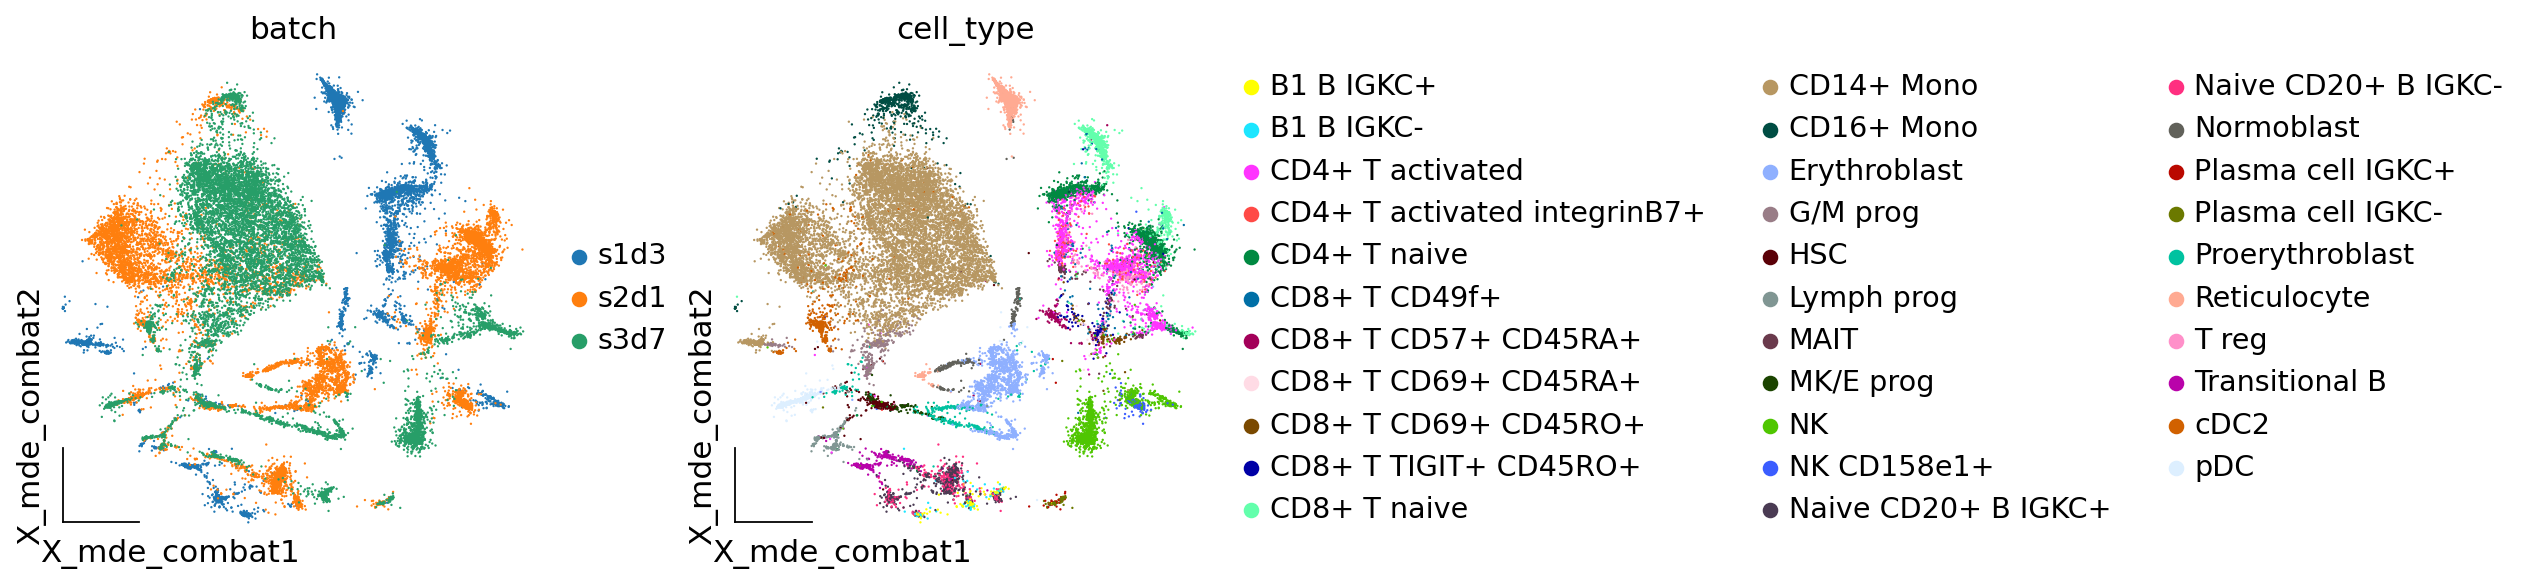

In [22]:
ov.utils.embedding(adata,
                basis='X_mde_combat',frameon='small',
                color=['batch','cell_type'],show=False)

## scanorama

Integration of single-cell RNA sequencing (scRNA-seq) data from multiple experiments, laboratories and technologies can uncover biological insights, but current methods for scRNA-seq data integration are limited by a requirement for datasets to derive from functionally similar cells. We present Scanorama, an algorithm that identifies and merges the shared cell types among all pairs of datasets and accurately integrates heterogeneous collections of scRNA-seq data. 

![scanorama](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41587-019-0113-3/MediaObjects/41587_2019_113_Fig1_HTML.png?as=webp)

In [23]:
adata_scanorama=ov.single.batch_correction(adata,batch_key='batch',
                                        methods='scanorama',n_pcs=50)
adata

s1d3
s2d1
s3d7
Found 3000 genes among all datasets
[[0.         0.46109705 0.43679325]
 [0.         0.         0.75170775]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
(26970, 50)


AnnData object with n_obs × n_vars = 26970 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_features'
    uns: 'scrublet', 'layers_counts', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'cel

In [24]:
adata.obsm["X_mde_scanorama"] = ov.utils.mde(adata.obsm["X_scanorama"])

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>]

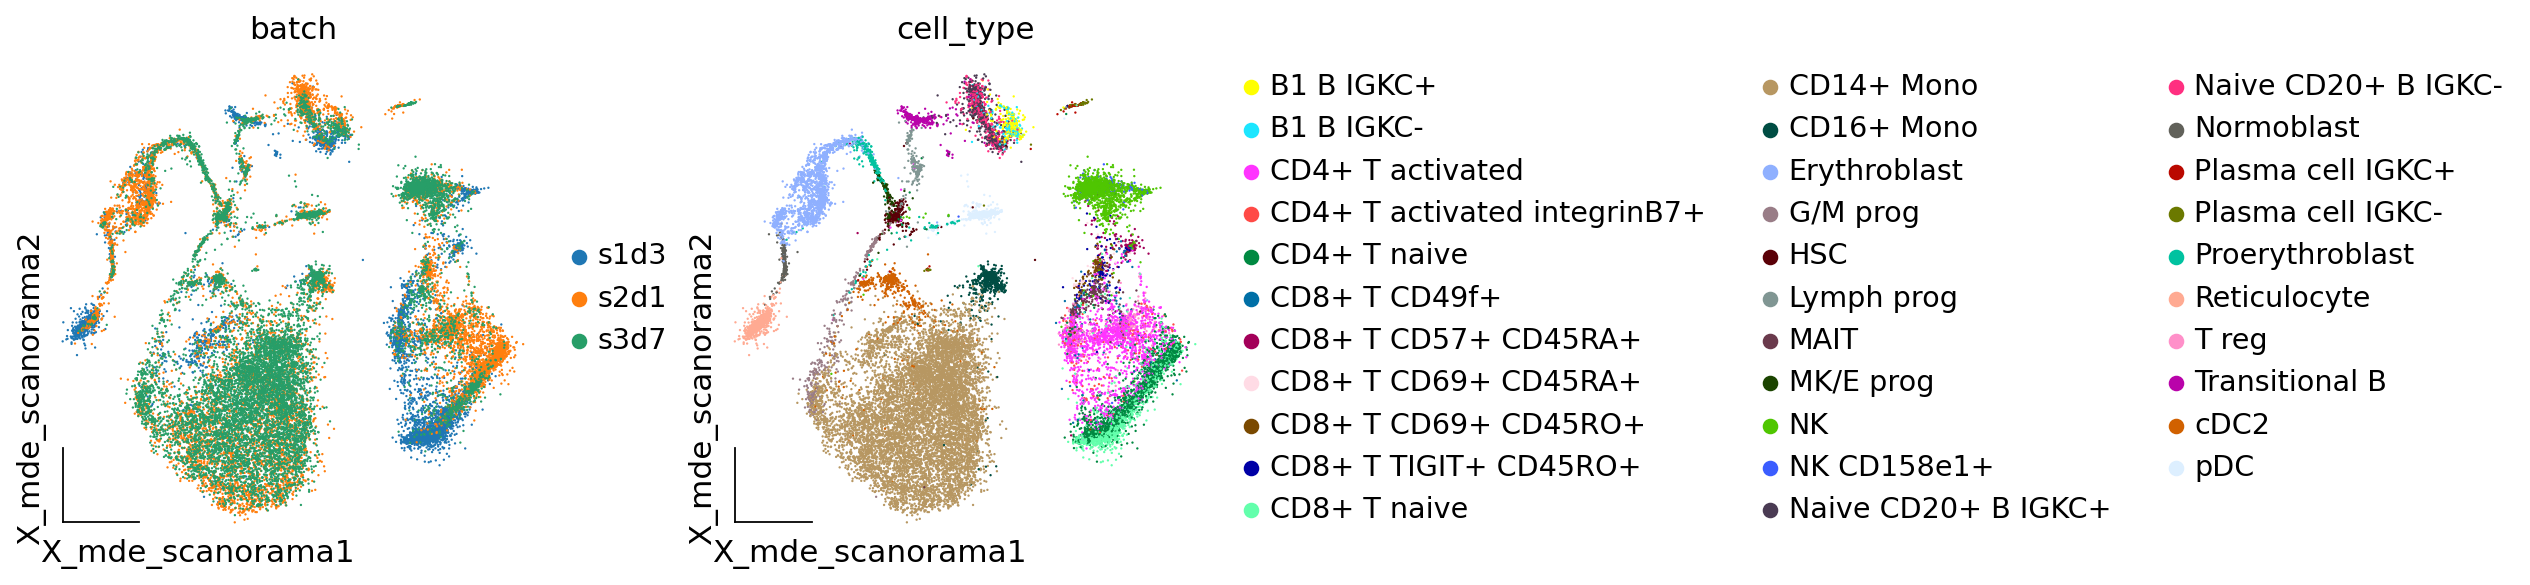

In [25]:
ov.utils.embedding(adata,
                basis='X_mde_scanorama',frameon='small',
                color=['batch','cell_type'],show=False)

## Benchmarking test

The methods demonstrated here are selected based on results from benchmarking experiments including the single-cell integration benchmarking project [Luecken et al., 2021]. This project also produced a software package called [scib](https://www.github.com/theislab/scib) that can be used to run a range of integration methods as well as the metrics that were used for evaluation. In this section, we show how to use this package to evaluate the quality of an integration.

In [26]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca'].copy()

In [ ]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "X_combat", "X_harmony",
                         'X_scanorama'],
    n_jobs=8,
)
bm.benchmark()

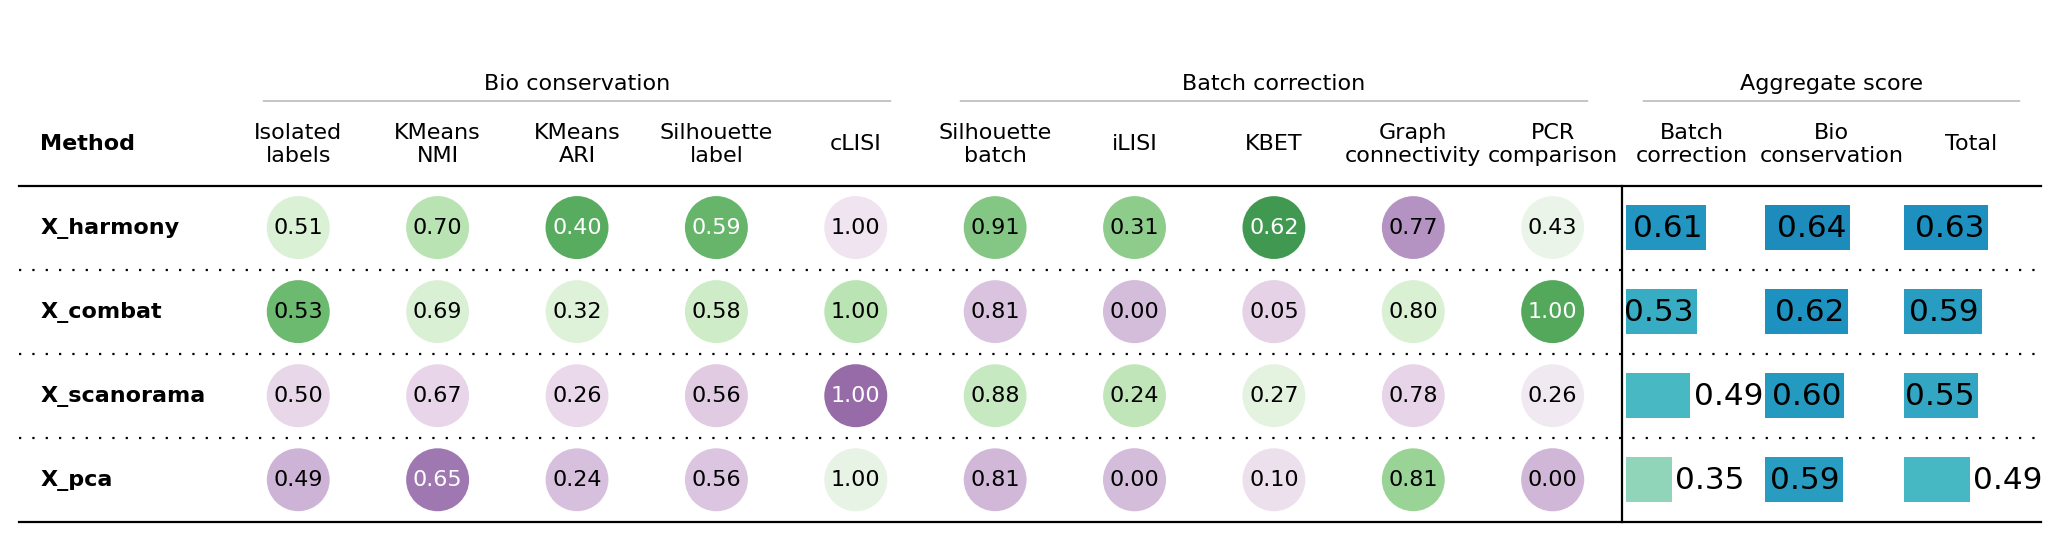

In [28]:
bm.plot_results_table(min_max_scale=False)

We can find that harmony removes the batch effect the best of the three methods that do not use the GPU